In [132]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras import callbacks
from keras import ops
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd
from scipy.stats import linregress
from molmass import Formula


from scipy.special import erf, erfinv
from matplotlib.colors import Normalize
from matplotlib import colors
from matplotlib import cm
import itertools
from scipy.stats import entropy
from scipy.interpolate import interpn

from support import *
MASS_H2 = Formula('H2').mass



#### Data pre-process and visualization

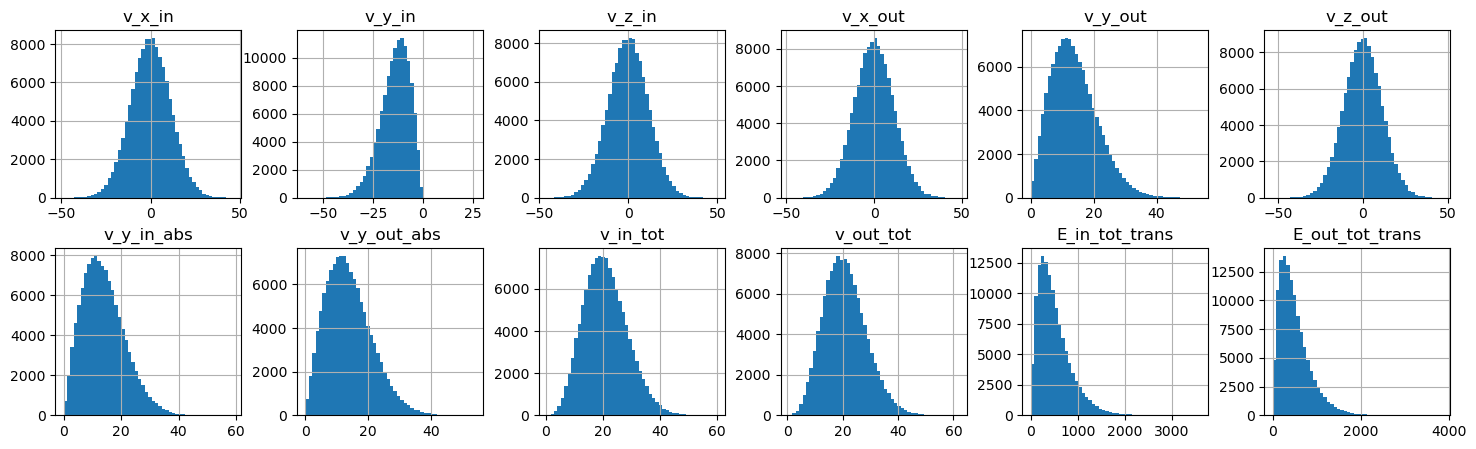

In [27]:
filename = 'D:/OneDrive - TU Eindhoven/Quartile_4/4AI000_Machine learning for Multi-physics modelling and design/Materials_for_ML_assignment_2024/H2_IsoThermalWalls_Sw_0/H2_Vel_MD_Sw_0_B300_Th_300.txt'
names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)

names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)


# Creating columns for overall velocities
df_trans_vel['v_y_in_abs'] = np.absolute(df_trans_vel["v_y_in"])
df_trans_vel['v_y_out_abs'] = np.absolute(df_trans_vel["v_y_out"])
df_trans_vel['v_in_tot'] = (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2))**0.5
df_trans_vel['v_out_tot'] = (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2))**0.5
df_trans_vel['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2)))
df_trans_vel['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2)))

# Plot the data
df_trans_vel.hist(bins = 50, layout= (2,6), figsize= (18,5))

x = df_trans_vel.loc[:, ].values

# Normalization
scaler = MinMaxScaler()
min_max_values = scaler.fit(x)
x_norm = scaler.fit_transform(x) 

# Create dataframe with normalized values
names_trans_vel_norm = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out', 'v_y_in_abs', 'v_y_out_abs', 'v_in_tot','v_out_tot', 'E_in_tot_trans', 'E_out_tot_trans']
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel_norm)

# Convert dataframe to numpy arrays
x = df_trans_vel_norm[['v_x_in', 'v_y_in', 'v_z_in']].to_numpy()
y = df_trans_vel_norm[['v_x_out', 'v_y_out', 'v_z_out']].to_numpy()

### Selected components 

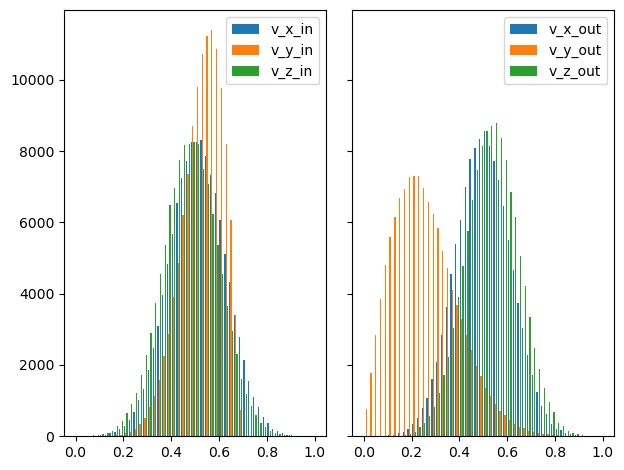

In [28]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = ['v_x_in','v_y_in','v_z_in'])
axs[1].hist(y, bins=n_bins, label = ['v_x_out','v_y_out','v_z_out'])
axs[0].legend()
axs[1].legend()
plt.show()

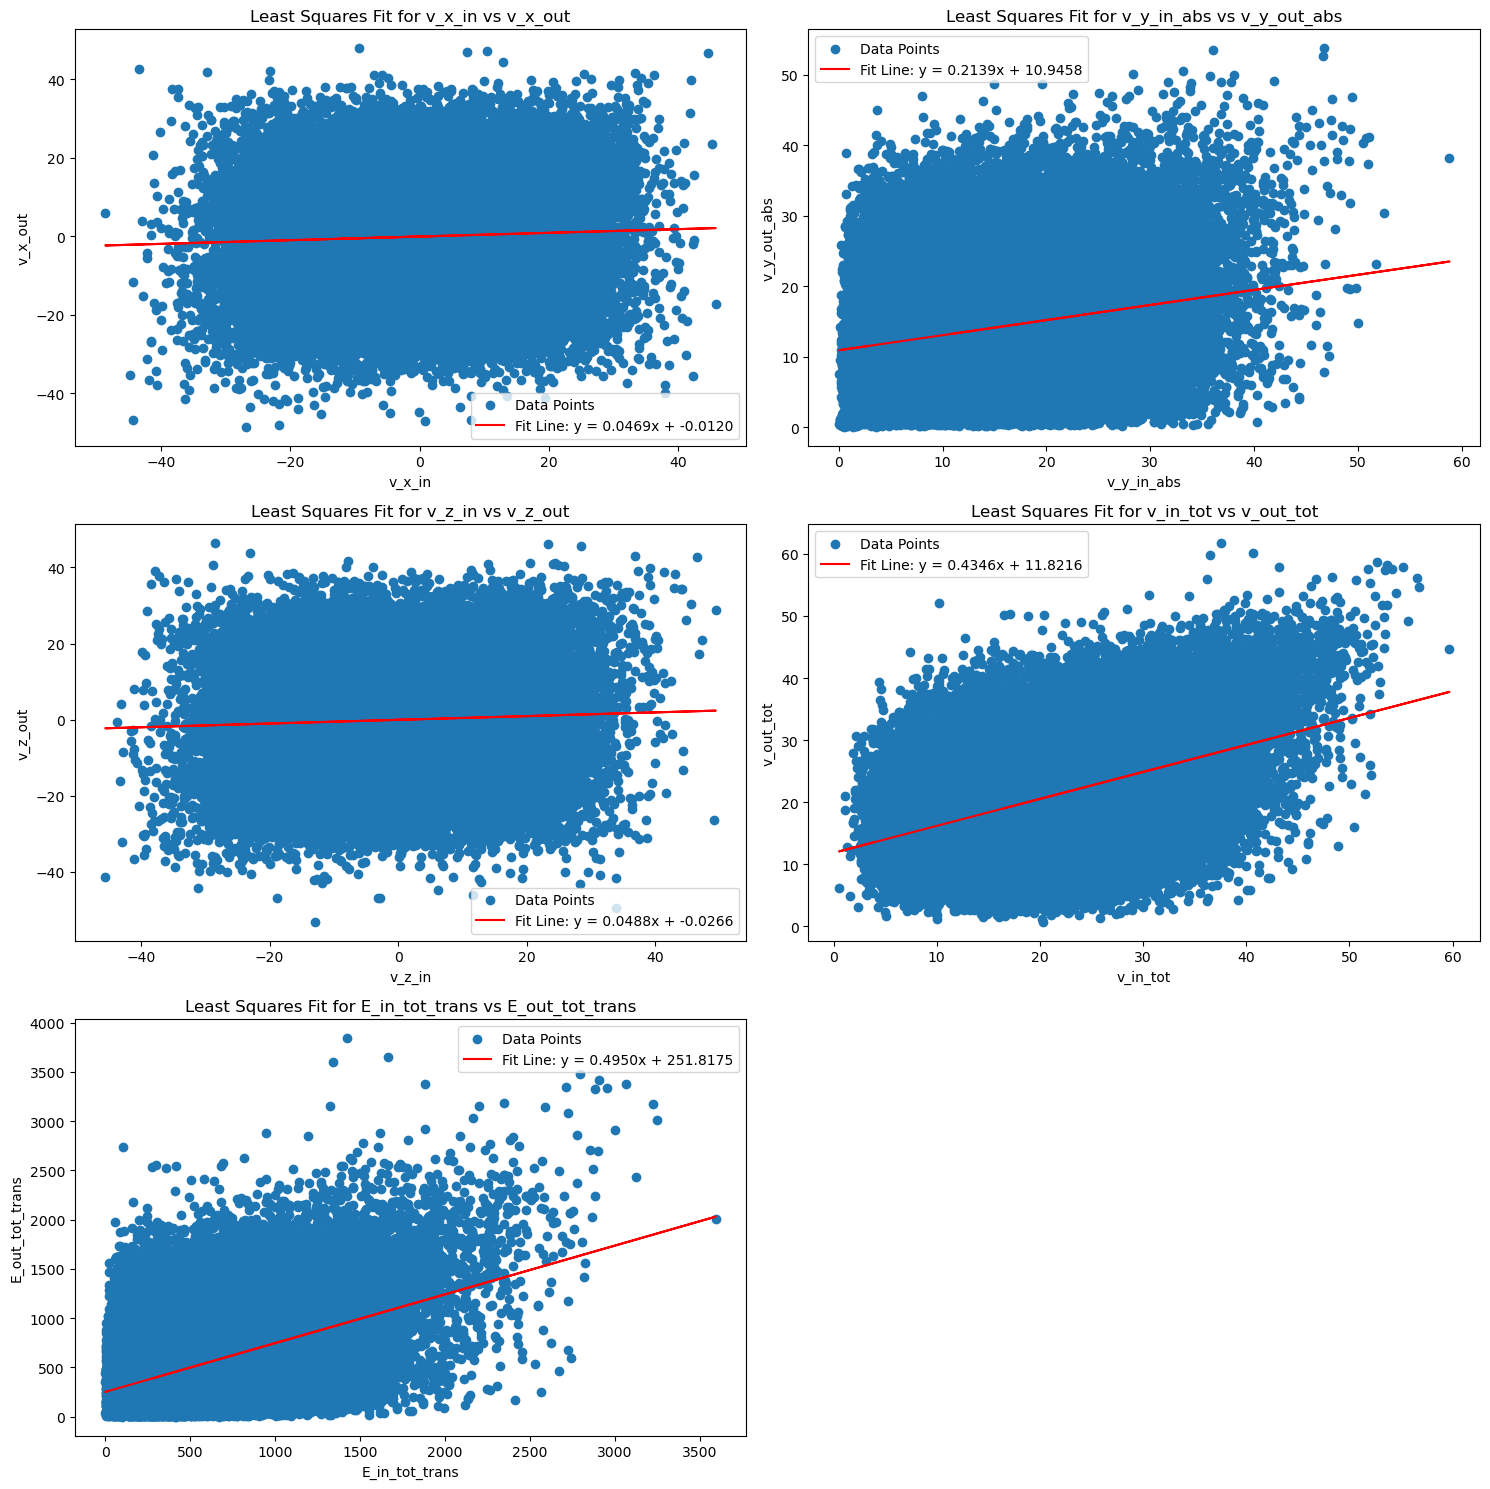

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.04688507804042502, Intercept = -0.012005181554984189, AC = 0.9531149219595749
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.21388442080783662, Intercept = 10.945823285642067, AC = 0.7861155791921633
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.04883952109373942, Intercept = -0.02661384601371122, AC = 0.9511604789062605
Slope, Intercept and AC for v_in_tot vs v_out_tot: Slope = 0.4346198807627179, Intercept = 11.821562905085724, AC = 0.565380119237282
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.4950291124734251, Intercept = 251.81749635655999, AC = 0.5049708875265748


In [29]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'), 
    ('v_y_in_abs', 'v_y_out_abs'), 
    ('v_z_in', 'v_z_out'), 
    ('v_in_tot', 'v_out_tot'),
    ('E_in_tot_trans', 'E_out_tot_trans')
    # Add more pairs as required
]

# Contour plots for all specified pairs
calculate_AC_scatter(df_trans_vel, cols_pairs)

#### MDN

#### Make train, test and validation split

In [43]:
# Test, train and validation split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=2)

In [44]:
# Reshaping the inputs and output tensors
x_1 = X_train[:,0].reshape((len(X_train[:]),1))
x_2 = X_train[:,1].reshape((len(X_train[:]),1))
x_3 = X_train[:,2].reshape((len(X_train[:]),1))
y_1 = y_train[:,0].reshape((len(y_train[:]),1))
y_2 = y_train[:,1].reshape((len(y_train[:]),1))
y_3 = y_train[:,2].reshape((len(y_train[:]),1))

x_1_val = X_val[:,0].reshape((len(X_val[:]),1))
x_2_val = X_val[:,1].reshape((len(X_val[:]),1))
x_3_val = X_val[:,2].reshape((len(X_val[:]),1))
y_1_val = y_val[:,0].reshape((len(y_val[:]),1))
y_2_val = y_val[:,1].reshape((len(y_val[:]),1))
y_3_val = y_val[:,2].reshape((len(y_val[:]),1))

x_1_test = X_test[:,0].reshape((len(X_test[:]),1))
x_2_test = X_test[:,1].reshape((len(X_test[:]),1))
x_3_test = X_test[:,2].reshape((len(X_test[:]),1))
y_1_test = y_test[:,0].reshape((len(y_test[:]),1))
y_2_test = y_test[:,1].reshape((len(y_test[:]),1))
y_3_test = y_test[:,2].reshape((len(y_test[:]),1))


#### Define MDN architecture

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1, 32)     │         64 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1, 32)     │         64 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 32)     │         64 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1, 32)     │      1,056 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1, 32)     │      1,056 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1, 32)     │      1,056 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      3,960 │ dense_29[0][0]    │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      3,960 │ dense_31[0][0]    │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      3,960 │ dense_33[0][0]    │
│ (MixtureDensityOut… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,240 (59.53 KB)

 Trainable params: 15,240 (59.53 KB)

 Non-trainable params: 0 (0.00 B)

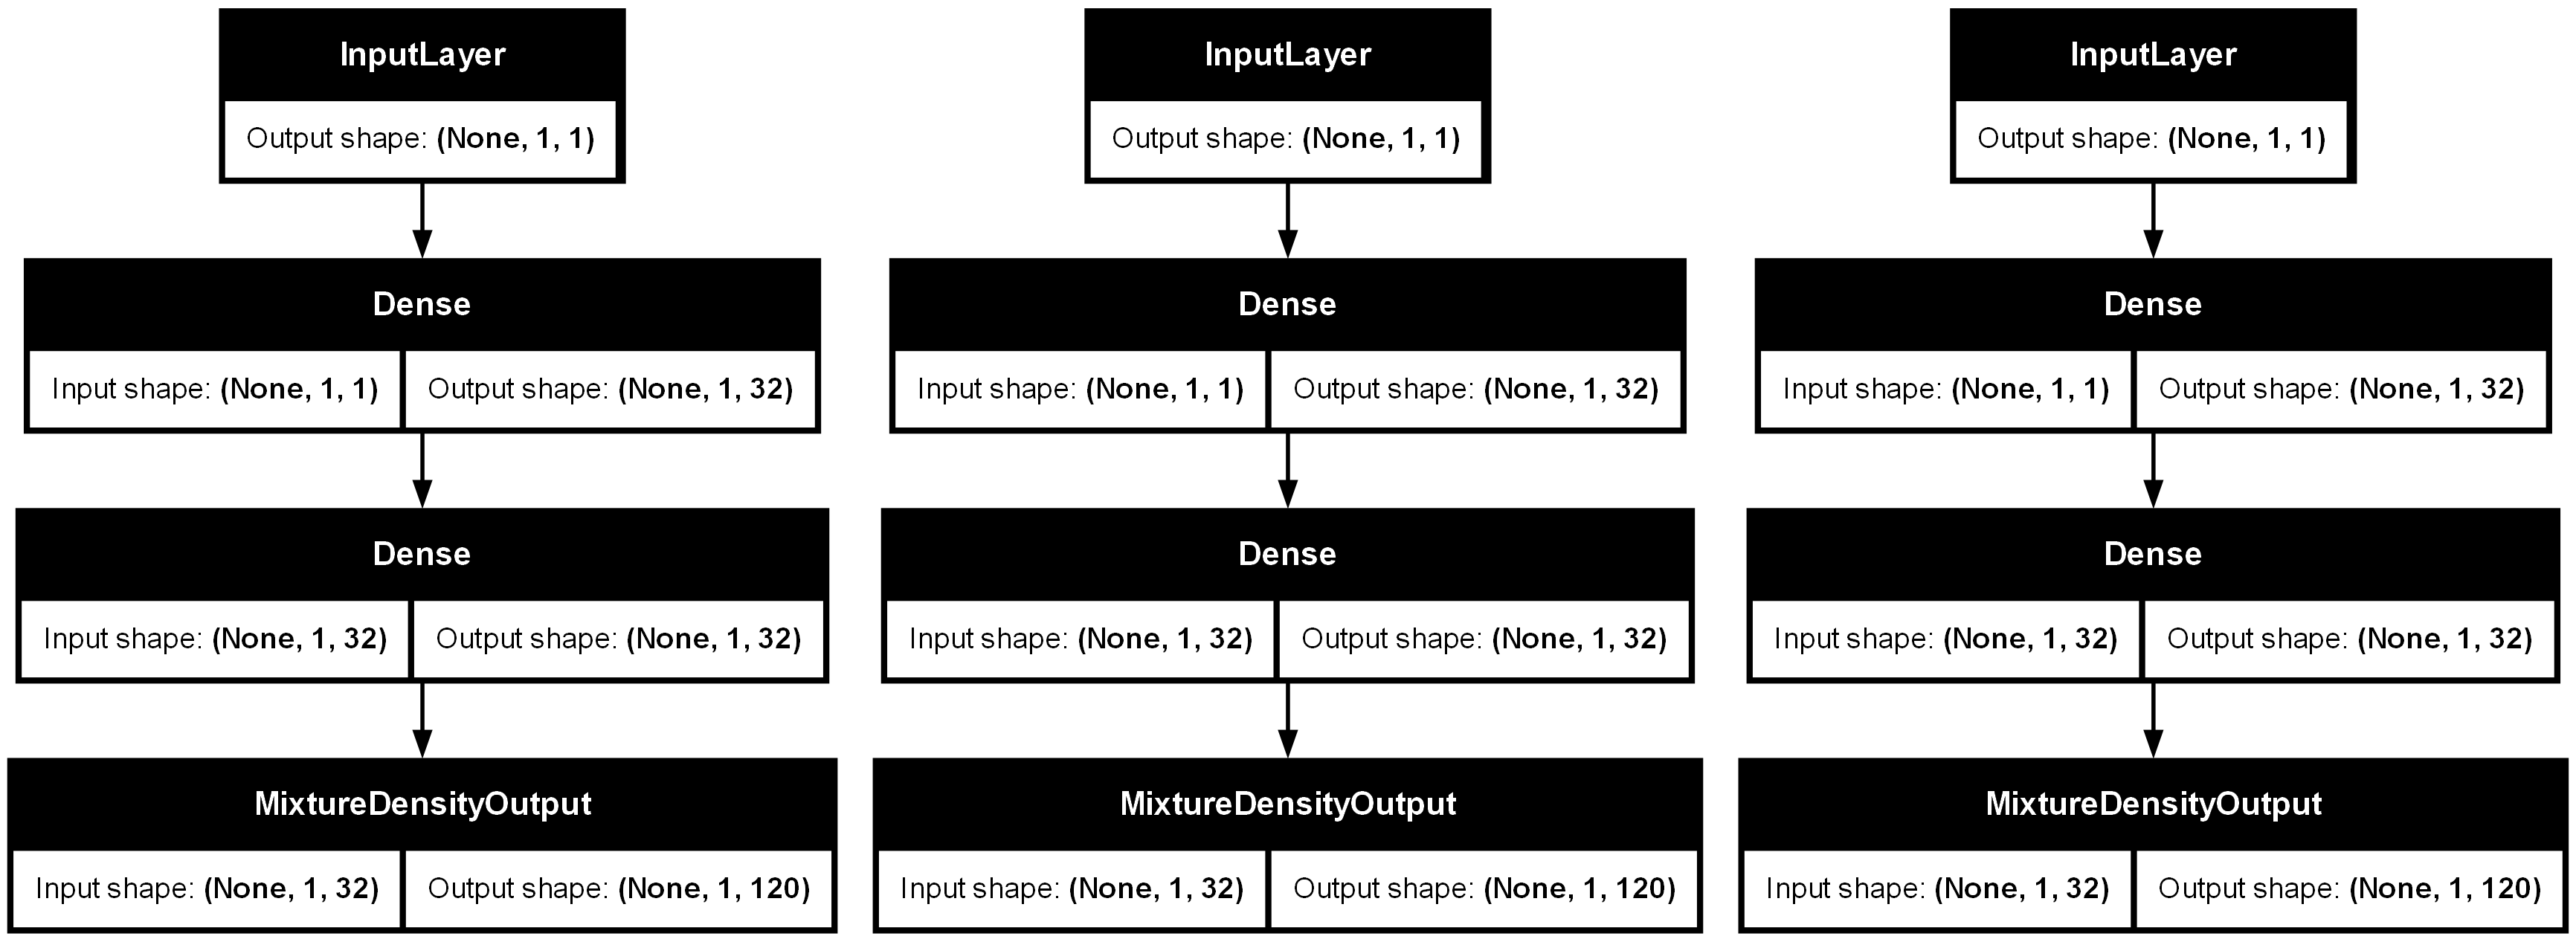

In [128]:
# n_Units = 64
# N_MIXES = 54
# OUTPUT_DIMS = 1

# lr = 0.001
# loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
# optimizer = optimizers.Adam(learning_rate=lr)
# activation = "relu"

# def model(num_Mixes, n_Units, optimizer, loss_function):
#     inputs1 = keras.Input(shape=(1, 1))
#     inputs2 = keras.Input(shape=(1, 1))
#     inputs3 = keras.Input(shape=(1, 1))

#     concat_layer = layers.concatenate([inputs1, inputs2, inputs3])
#     dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

#     x1 = layers.Dense(units=n_Units, activation= activation)(dense_layer)
#     #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
#     block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

#     x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
#     #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
#     block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


#     x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
#     #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
#     block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

#     model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
#     model.compile(
#         optimizer=optimizer,
#         loss= loss_function
#         )
#     return model

# mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

# mdn_network.summary()

# keras.utils.plot_model(mdn_network, show_shapes=True)

# OLD MODEL 

n_Units = 32
N_MIXES = 40
OUTPUT_DIMS = 1

lr = 0.001
loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = "adam" #optimizers.Adam(learning_rate=lr)
activation = "relu"

def model(num_Mixes, n_Units, optimizer, loss_function):
    inputs1 = keras.Input(shape=(1, 1))
    x1 = layers.Dense(units=n_Units, activation= activation)(inputs1)
    x1 = layers.Dense(units=n_Units, activation= activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    inputs2 = keras.Input(shape=(1, 1))
    x2 = layers.Dense(units=n_Units, activation= activation)(inputs2)
    x2 = layers.Dense(units=n_Units, activation= activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)

    inputs3 = keras.Input(shape=(1, 1))
    x3 = layers.Dense(units=n_Units, activation=activation)(inputs3)
    x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
    model.compile(
        optimizer=optimizer,
        loss= loss_function
        )
    return model

mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

mdn_network.summary()

keras.utils.plot_model(mdn_network, show_shapes=True)

#### Train

In [129]:
epochs = 200

history = mdn_network.fit(
    [x_1, x_2, x_3],
    [y_1, y_2, y_3],
    epochs=epochs,
    batch_size = 256,
    validation_split=0.10,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 117s 93ms/step - loss: 1.1271 - val_loss: -2.0599 - learning_rate: 0.0010
Epoch 2/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: -2.0578 - val_loss: -2.1358 - learning_rate: 0.0010
Epoch 3/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: -2.1284 - val_loss: -2.1579 - learning_rate: 0.0010
Epoch 4/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: -2.1570 - val_loss: -2.1675 - learning_rate: 0.0010
Epoch 5/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: -2.1515 - val_loss: -2.1663 - learning_rate: 0.0010
Epoch 6/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: -2.1700 - val_loss: -2.1706 - learning_rate: 0.0010
Epoch 7/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: -2.1658 - val_loss: -2.1726 - learning_rate: 0.0010
Epoch 8/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: -2.1693 - val_loss: -2.1767 - learning_rate: 0.0010
Epoch 9/200
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: -2.1625 - val_loss: -2.17

### Hyperparameter tuning - Defining search space and optimization

In [36]:
def model(hp, num_Mixes = 20, n_Units = 32, activation = 'relu',  dropout = False, dropout_rate = 0.2, optimizer = "", lr = 0.001):

    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))
    inputs3 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2, inputs3])
    dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

    x1 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
    
    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss= get_mixture_loss_func(1, num_Mixes)
        )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers, excluding output layer
    num_Layers = hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices for number of layers, excluding output layer
    num_Units = hp.Int("num_layers", min_value=32, max_value=32, step=32)   

    # Choices of activation
    activation = hp.Choice("activation", ["relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    # dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    # dropout_rate = hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    optimizer = hp.Choice("optimizer", ["adam"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, 
        num_Mixes=num_Mixes, 
        n_Units = num_Units,  
        activation=activation, 
        #num_Layers=num_Layers,
        #dropout_rate= dropout_rate, 
        #dropout=dropout,  
        optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# Bayesion optimization 

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam'], 'ordered': False}


In [63]:
# def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, optimizer = ""):
#     model =  keras.Sequential()
    
#     for i in range(1, num_Layers+1):
#         model.add(
#             layers.Dense(
#                 units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
#                 activation=activation)
#         )
#         if dropout:
#             model.add(layers.Dropout(dropout_rate=0.2))   
    
#     model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

#     if optimizer == 'Adam':
#         optimizer = optimizers.Adam(learning_rate=lr)
#     elif optimizer == 'AdamW':
#         optimizer = optimizers.AdamW(learning_rate=lr)
#     elif optimizer == 'Nadam':
#         optimizer = optimizers.Nadam(learning_rate=lr)
#     elif optimizer == 'Adadelta':
#         optimizer = optimizers.Adadelta(learning_rate=lr)        
#     else:
#         optimizer = optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = optimizer,
#         loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
#     )
#     return model

# # Define hyper-parameter search space
# def build_model(hp):

#     # Choices for number of Mixtures - an important advantage of using MDN
#     num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=50, step=1)
    
#     # Choices for number of layers
#     num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

#     # Choices of activation
#     activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
#     # Choice on dropout
#     dropout = hp.Boolean("dropout", [True, False])

#     # Choices on dropout rate
#     dropout_rate = hp.Float ("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

#     # Choices on learning rate
#     optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
#     # Call existing model-building code with the hyperparameter values.
#     mdn_network = model(
#         hp, num_Mixes=num_Mixes, 
#         num_Layers=num_Layers, 
#         activation=activation, 
#         dropout_rate= dropout_rate, 
#         dropout=dropout,  
#         optimizer = optimizer
#     )
#     return mdn_network


# build_model(keras_tuner.HyperParameters())

# # Directory to store the models during hyper-parameter tuning 
# directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# tuner = keras_tuner.BayesianOptimization(
#     hypermodel= build_model,
#     max_trials= 40,
#     objective = "loss",
#     alpha=0.0001,
#     beta=2.6,
#     seed= 1,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     project_name="models_4AI000",
#     overwrite = True,
# )

# # tuner = keras_tuner.RandomSearch(
# #     hypermodel=build_model,
# #     objective="loss",
# #     max_trials=3,
# #     executions_per_trial=2,
# #     overwrite=True,
# #     directory= directory,
# #     project_name="4AI000",
# # )

# tuner.search_space_summary()

### Perform hyper-parameter tuning

In [119]:
epochs = 10
tuner.search([x_1, x_2, x_3], [y_1, y_2, y_3], epochs= epochs, validation_data=([x_1_val, x_2_val, x_3_val],[y_1_val, y_2_val, y_3_val]))

Trial 13 Complete [00h 03m 50s]

Best loss So Far: -2.173656702041626
Total elapsed time: 01h 31m 15s


#### Compile model with best hyper-parameters 

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])

print("The best hyper-parameters are")
print(best_hps[0].values)

The best hyper-parameters are
{'num_Mixes': 44, 'num_layers': 1, 'activation': 'relu', 'units_1': 32}


### Summary of best model

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixture_density_output          │ (None, 132)            │         4,356 │
│ (MixtureDensityOutput)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420 (17.27 KB)

 Trainable params: 4,420 (17.27 KB)

 Non-trainable params: 0 (0.00 B)

### Training the best model

In [ ]:
history = mdn_network.fit(
    [x_1, x_2, x_3],
    [y_1, y_2, y_3],
    epochs=100,
    batch_size = 128,
    validation_split=0.05,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100


ValueError: Layer 'functional_1' expected 3 input(s). Received 1 instead.

### Plot Loss

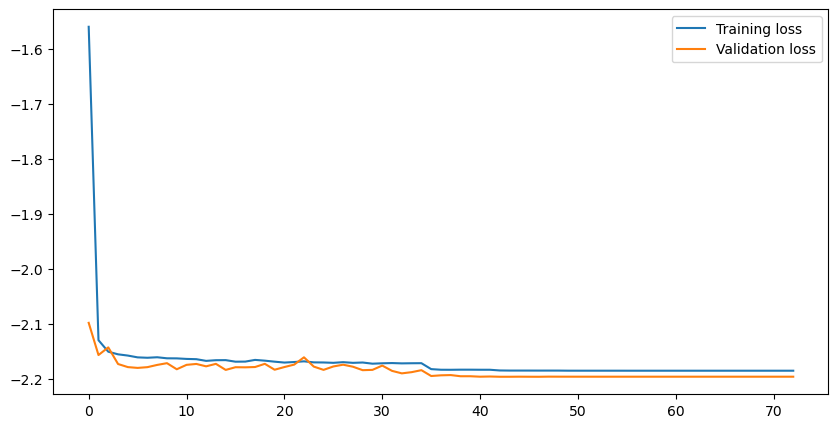

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [123]:
y_pred_mixture = mdn_network.predict((x_1_test,x_2_test, x_3_test))

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


In [124]:
# Reshape and sampling
y_new = []
y_samples = []
for i in range(len(y_pred_mixture)):
    y_new.append(y_pred_mixture[i].reshape((len(y_pred_mixture[0]),N_MIXES*3)))
    y_samples.append(np.apply_along_axis(sample_from_output, 1, y_new[i], 1, N_MIXES, temp=1.0))
    y_samples[i] = y_samples[i].reshape((len(y_samples[i])))    

In [125]:
# Create data frame with results and original input/output velocities for plotting purpose

# Normalized dataframe that contains results - df_results_norm
# Renormalized df - df_results

df_results_norm = pd.DataFrame(y_samples).transpose()
df_results_norm.rename(columns = {0:'v_x_out_pred', 1:'v_y_out_pred',2:'v_z_out_pred'}, inplace = True)
df_results_norm['v_x_in'] = x_1_test
df_results_norm['v_y_in'] = x_2_test
df_results_norm['v_z_in'] = x_3_test
df_results_norm['v_x_out'] = y_1_test
df_results_norm['v_y_out'] = y_2_test
df_results_norm['v_z_out'] = y_3_test 


df_results = pd.DataFrame([])
df_results['v_x_in'] = re_normalize(df_results_norm['v_x_in'], min_max_values.data_min_[0], min_max_values.data_max_[0])
df_results['v_y_in'] = re_normalize(df_results_norm['v_y_in'], min_max_values.data_min_[1], min_max_values.data_max_[1])
df_results['v_z_in'] = re_normalize(df_results_norm['v_z_in'], min_max_values.data_min_[2], min_max_values.data_max_[2])
df_results['v_x_out'] = re_normalize(df_results_norm['v_x_out'], min_max_values.data_min_[3], min_max_values.data_max_[3])
df_results['v_y_out'] = re_normalize(df_results_norm['v_y_out'], min_max_values.data_min_[4], min_max_values.data_max_[4])
df_results['v_z_out'] = re_normalize(df_results_norm['v_z_out'], min_max_values.data_min_[5], min_max_values.data_max_[5])
df_results['v_x_out_pred'] = re_normalize(df_results_norm['v_x_out_pred'], min_max_values.data_min_[3], min_max_values.data_max_[3])
df_results['v_y_out_pred'] = re_normalize(df_results_norm['v_y_out_pred'], min_max_values.data_min_[4], min_max_values.data_max_[4])
df_results['v_z_out_pred'] = re_normalize(df_results_norm['v_z_out_pred'], min_max_values.data_min_[5], min_max_values.data_max_[5])

# Creating columns for overall velocities
df_results_norm['v_y_in_abs'] = np.absolute(df_results_norm["v_y_in"])
df_results_norm['v_y_out_abs'] = np.absolute(df_results_norm["v_y_out"])
df_results_norm['v_y_out_abs_pred'] = np.absolute(df_results_norm["v_y_out_pred"])
df_results_norm['v_in_tot'] = (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2))**0.5
df_results_norm['v_out_tot'] = (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2))**0.5
df_results_norm['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2)))
df_results_norm['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2)))
df_results_norm['E_out_tot_trans_pred'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out_pred"],2)+ np.power(df_results_norm["v_y_out_pred"],2) + np.power(df_results_norm["v_z_out_pred"],2)))


# Creating columns for overall velocities
df_results['v_y_in_abs'] = np.absolute(df_results["v_y_in"])
df_results['v_y_out_abs'] = np.absolute(df_results["v_y_out"])
df_results['v_y_out_abs_pred'] = np.absolute(df_results["v_y_out_pred"])
df_results['v_in_tot'] = (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2))**0.5
df_results['v_out_tot'] = (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2))**0.5
df_results['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2)))
df_results['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2)))
df_results['E_out_tot_trans_pred'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out_pred"],2)+ np.power(df_results["v_y_out_pred"],2) + np.power(df_results["v_z_out_pred"],2)))



#### Apply Liao tranform for MDN predicted data 

In [130]:
kB = 1.38064852e-23
conv_v = 1.0e2

direction = 'y'

x_y = df_results_norm[['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']].to_numpy() 
v_TR,T_in,T_out,theta_in,theta_out = liao_transform(x_y, MASS_H2, direction)

df_test_liao = pd.DataFrame([])
df_test_liao['v_x_in'] = v_TR[:,0]
df_test_liao['v_y_in'] = v_TR[:,1]
df_test_liao['v_z_in'] = v_TR[:,2]
df_test_liao['v_x_out'] = v_TR[:,3]
df_test_liao['v_y_out'] = v_TR[:,4]
df_test_liao['v_z_out'] = v_TR[:,5]

x_y = df_results_norm[['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out_pred', 'v_y_out_pred', 'v_z_out_pred']].to_numpy() 
v_TR_1,T_in_1,T_out_1,theta_in_1,theta_out_1 = liao_transform(x_y, MASS_H2, direction)
df_results_liao = pd.DataFrame([])
df_results_liao['v_x_in'] = v_TR_1[:,0]
df_results_liao['v_y_in'] = v_TR_1[:,1]
df_results_liao['v_z_in'] = v_TR_1[:,2]
df_results_liao['v_x_out'] = v_TR_1[:,3]
df_results_liao['v_y_out'] = v_TR_1[:,4]
df_results_liao['v_z_out'] = v_TR_1[:,5]

df_test_liao.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test_liao.dropna(axis= 0, how='any')
df_results_liao.replace([np.inf, -np.inf], np.nan, inplace=True)
df_results_liao.dropna(axis= 0, how='any')



,v_x_in,v_y_in,v_z_in,v_x_out,v_y_out,v_z_out
0,0.401446,-0.084898,0.458492,0.384400,-0.146437,0.489000
1,0.413087,-0.015066,0.463828,0.560159,-0.775468,0.670813
2,0.571583,0.163873,0.287448,0.450573,-0.082249,0.553947
3,0.388376,0.056171,0.524057,0.427417,-0.473080,0.635706
4,0.563412,0.113553,0.580390,0.404749,-0.156468,0.470284
...,...,...,...,...,...,...
74007,-0.422091,0.041409,-0.598814,-0.502250,-0.155957,-0.328376
74008,-0.714018,-0.206034,-0.418262,-0.533242,-0.309892,-0.572919
74009,-0.758391,-0.127769,-0.390154,-0.590480,0.139843,-0.638830
74010,-0.367971,0.076291,-0.260097,-0.602599,-0.496377,-0.507470


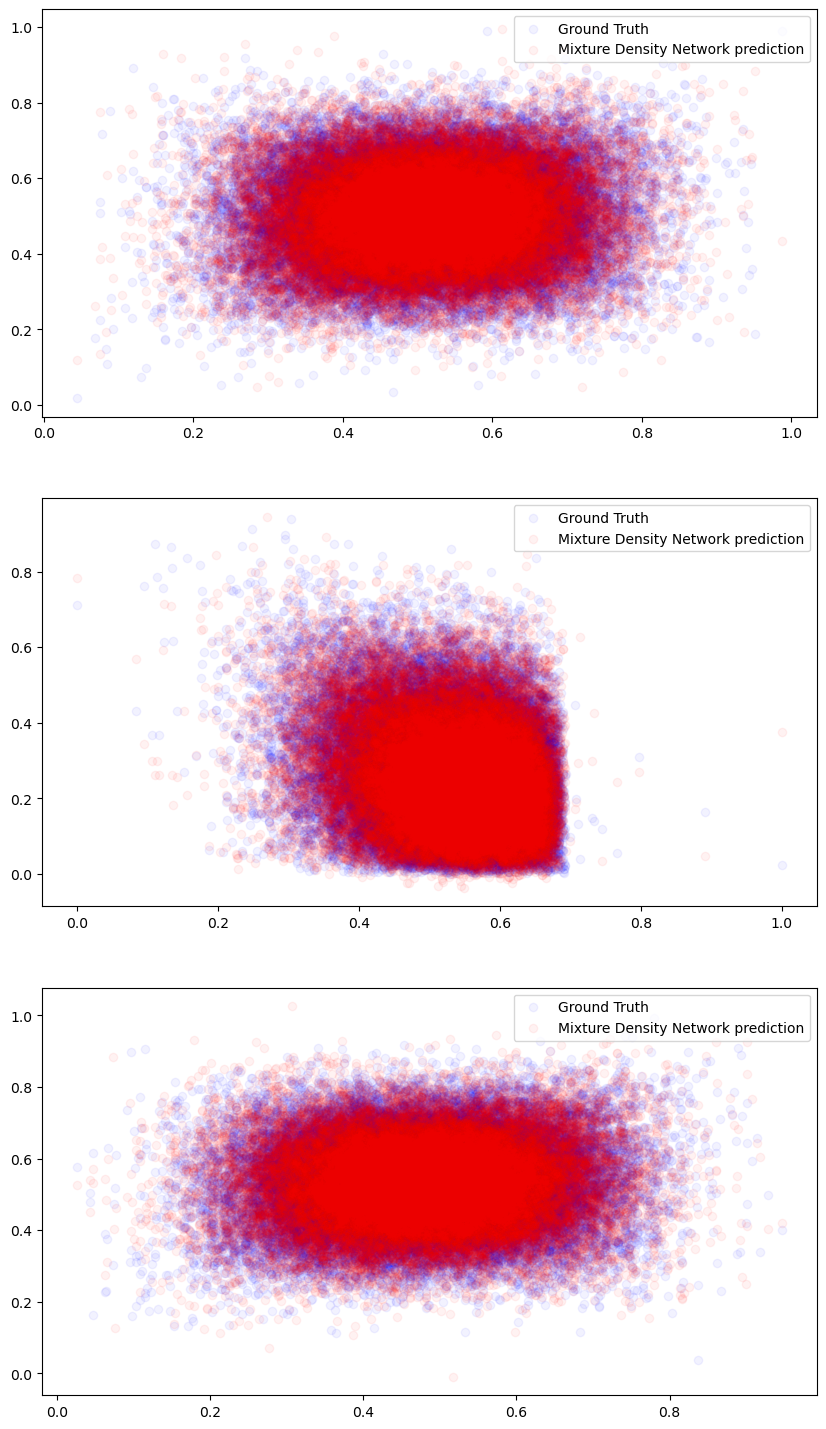

In [133]:
fig, axs = plt.subplots(3, 1, figsize = (10,18))
axs[0].scatter(df_results_norm['v_x_in'], df_results_norm['v_x_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[0].scatter(df_results_norm['v_x_in'], df_results_norm['v_x_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[0].legend(loc = 1)
axs[1].scatter(df_results_norm['v_y_in'], df_results_norm['v_y_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[1].scatter(df_results_norm['v_y_in'], df_results_norm['v_y_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[1].legend(loc = 1)
axs[2].scatter(df_results_norm['v_z_in'], df_results_norm['v_z_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[2].scatter(df_results_norm['v_z_in'], df_results_norm['v_z_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[2].legend(loc = 1)

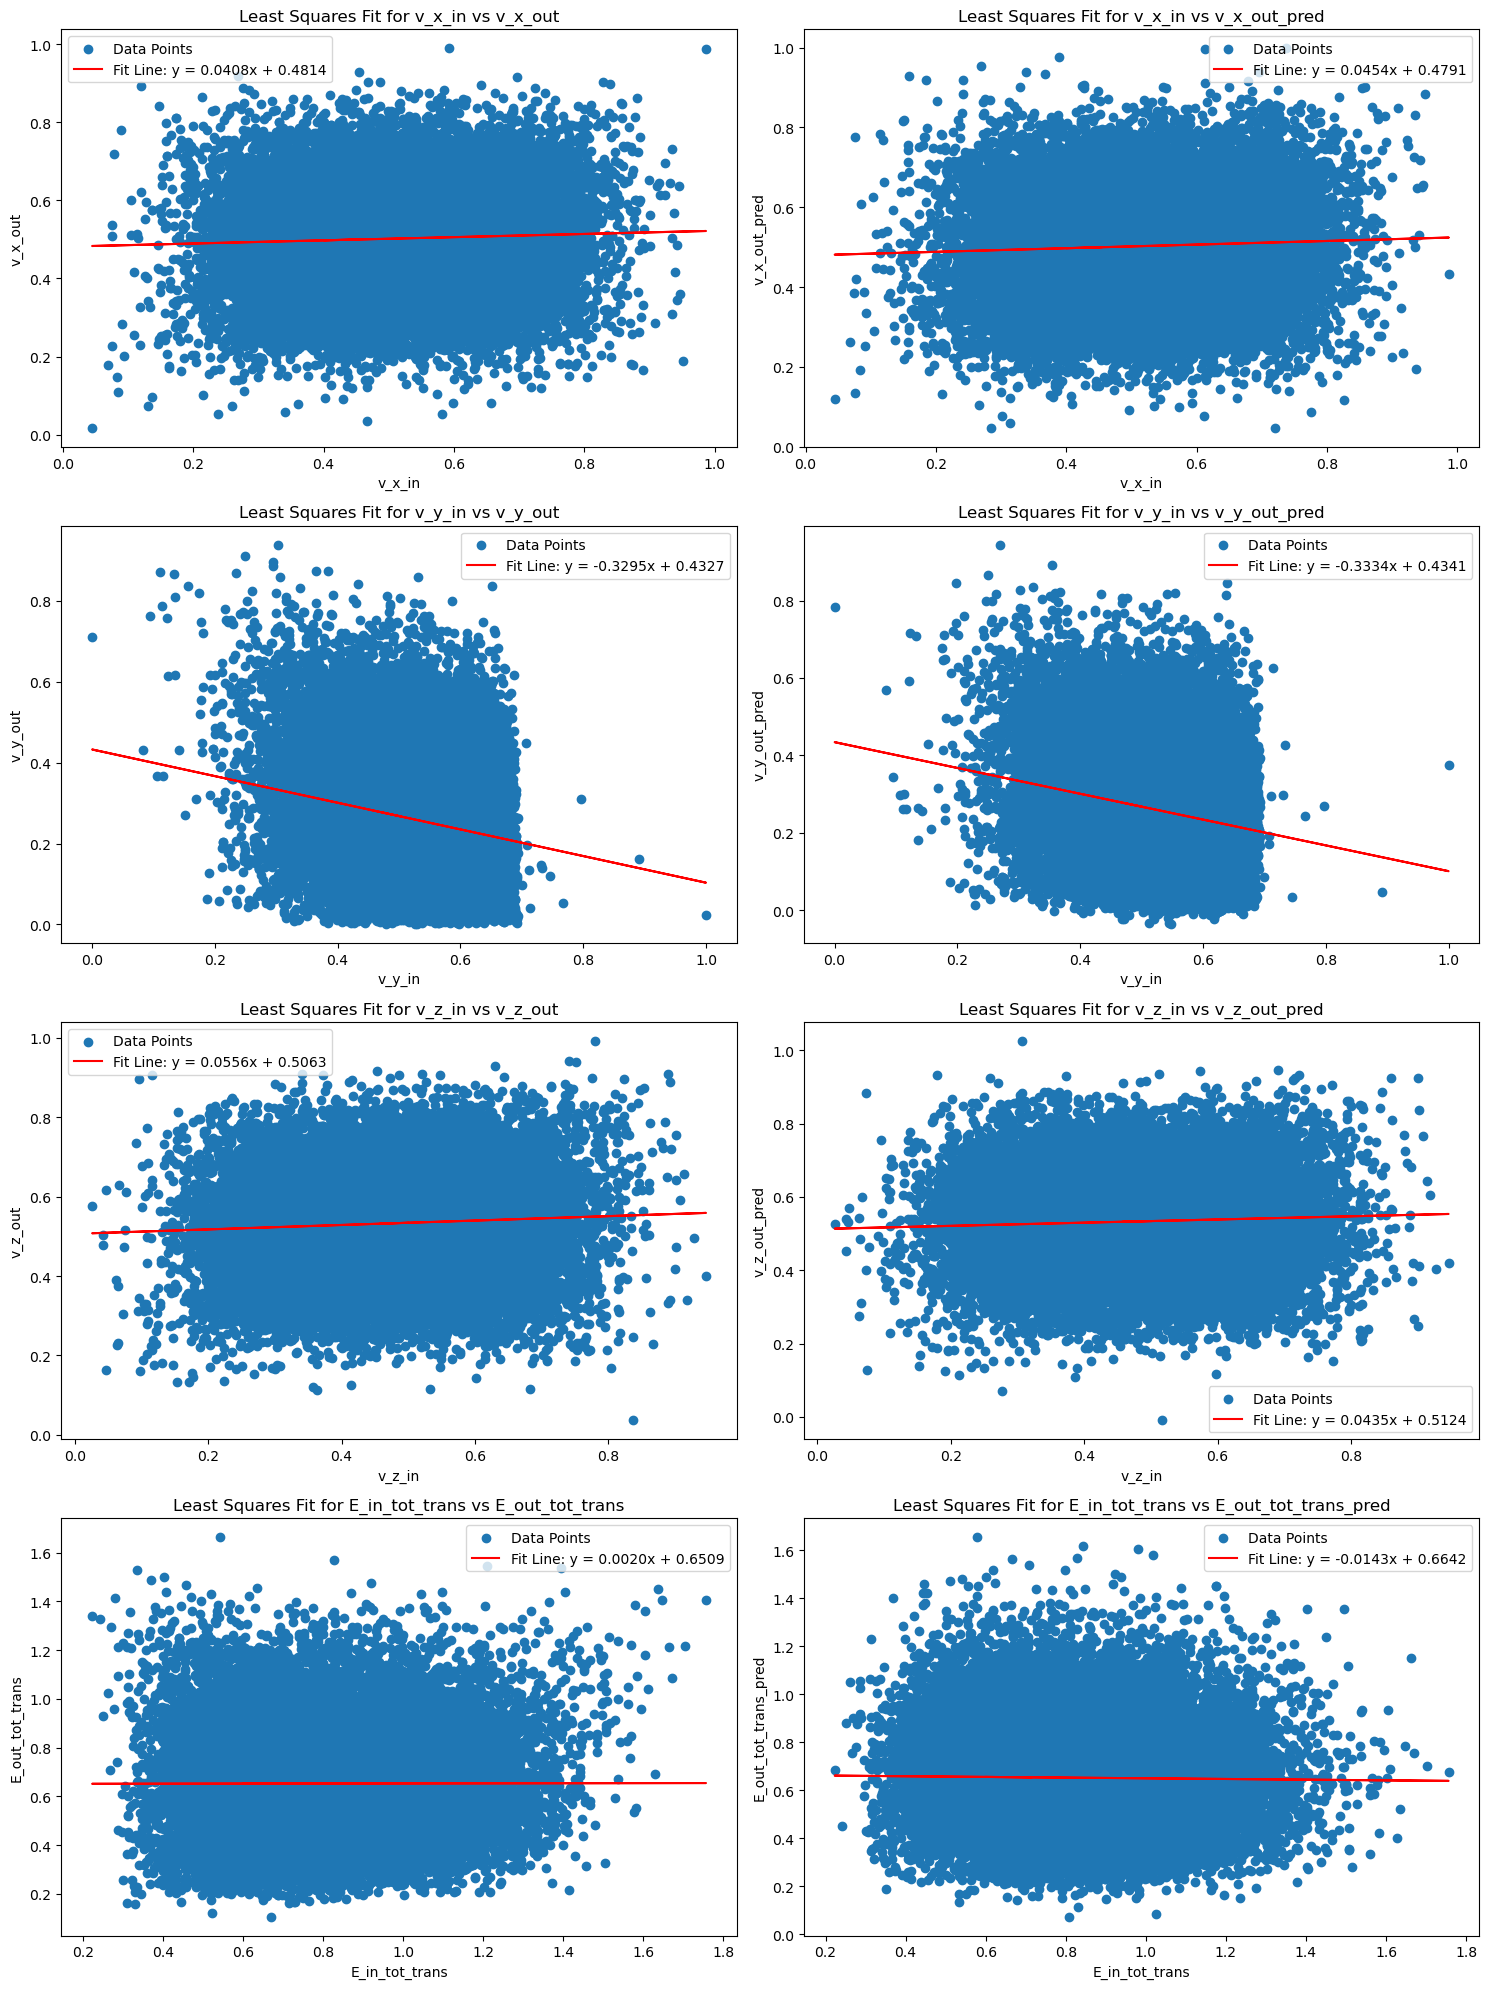

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.0408051941189072, Intercept = 0.48136168834172927, AC = 0.9591948058810928
Slope, Intercept and AC for v_x_in vs v_x_out_pred: Slope = 0.04538520384276774, Intercept = 0.479138643418762, AC = 0.9546147961572322
Slope, Intercept and AC for v_y_in vs v_y_out: Slope = -0.32948273885113616, Intercept = 0.4327079886894381, AC = 1.329482738851136
Slope, Intercept and AC for v_y_in vs v_y_out_pred: Slope = -0.3333615337767348, Intercept = 0.4340527524982786, AC = 1.3333615337767348
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.05562836317862523, Intercept = 0.5062776597606247, AC = 0.9443716368213748
Slope, Intercept and AC for v_z_in vs v_z_out_pred: Slope = 0.04345309495320511, Intercept = 0.5124211129209075, AC = 0.9565469050467948
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.0020416058923266437, Intercept = 0.6509051470117891, AC = 0.9979583941076734
Slope, Intercept and AC for E_in_tot_trans v

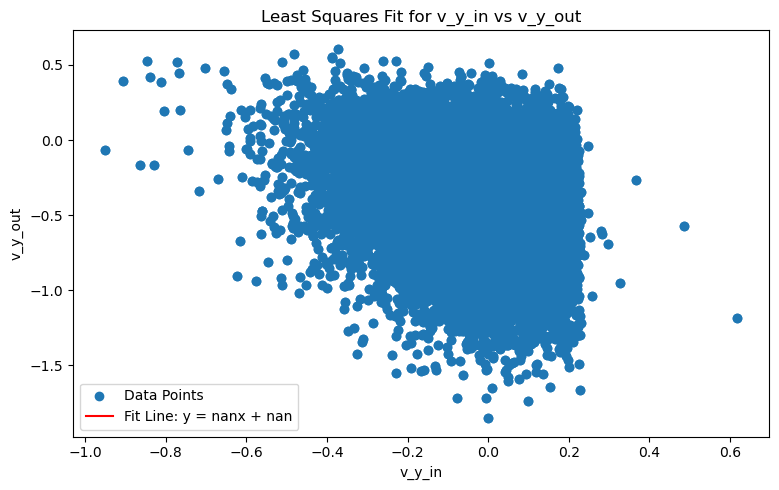

Slope, Intercept and AC for v_y_in vs v_y_out: Slope = nan, Intercept = nan, AC = nan


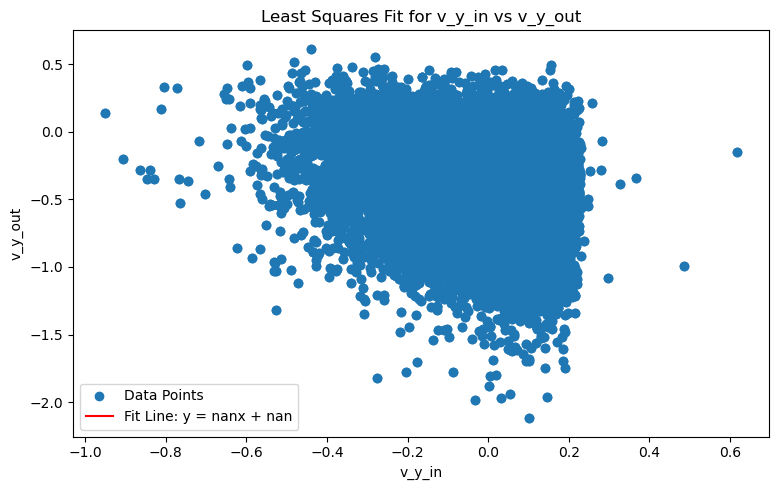

Slope, Intercept and AC for v_y_in vs v_y_out: Slope = nan, Intercept = nan, AC = nan


In [131]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'),
    ('v_x_in', 'v_x_out_pred'),   
    ('v_y_in', 'v_y_out'),
    ('v_y_in', 'v_y_out_pred'),
    ('v_z_in', 'v_z_out'), 
    ('v_z_in', 'v_z_out_pred'), 
    ('E_in_tot_trans', 'E_out_tot_trans'),
    ('E_in_tot_trans', 'E_out_tot_trans_pred') 
    # Add more pairs as required
]

calculate_AC_scatter(df_results_norm, cols_pairs)

cols_pairs1 = [
    ('v_y_in', 'v_y_out')
]
calculate_AC_scatter(df_test_liao, cols_pairs1)

# cols_pairs2 = [
#     ('v_y_in', 'v_y_out')
# ]
# calculate_AC_scatter(df_results_liao, cols_pairs2)